In [1]:
# ## Load in Data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Specify the data directory
path_to_files = "/D3/data/hweiner/Model_Obs_CoCoMET_out"
directory = os.fsencode(path_to_files)

# Load in the tracks
NEXRAD_tracks_unfiltered = pd.read_csv(f"{path_to_files}/NEXRAD_Tracks_tobac.csv")
RAMS_tracks_unfiltered = pd.read_csv(f"{path_to_files}/RAMS_Tracks_tobac.csv")

# Join all the analysis data into one dataframe for each dataset
nexrad_analysis_data_unfiltered = pd.DataFrame({})
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if ("nexrad_tobac" in filename and ".csv" in filename
        and "mergers" not in filename
        and "splitters" not in filename):
        if len(nexrad_analysis_data_unfiltered) < 3:
            nexrad_analysis_data_unfiltered = pd.read_csv(f"{path_to_files}/{filename}")
        else:
            f = pd.read_csv(f"{path_to_files}/{filename}")
            cols = set(f.keys()) - set(['frame', 'feature_id', 'cell_id'])
            for c in cols:
                nexrad_analysis_data_unfiltered = nexrad_analysis_data_unfiltered.join(f[c])

rams_analysis_data_unfiltered = pd.DataFrame({})
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if ("rams_tobac" in filename and ".csv" in filename
        and "mergers" not in filename
        and "splitters" not in filename):
        if len(rams_analysis_data_unfiltered) < 3:
            rams_analysis_data_unfiltered = pd.read_csv(f"{path_to_files}/{filename}")
        else:
            f = pd.read_csv(f"{path_to_files}/{filename}")
            cols = set(f.keys()) - set(['frame', 'feature_id', 'cell_id'])
            for c in cols:
                rams_analysis_data_unfiltered = rams_analysis_data_unfiltered.join(f[c])

rams_mergers = pd.read_csv(f"{path_to_files}/rams_tobac_mergers.csv")
nexrad_mergers = pd.read_csv(f"{path_to_files}/nexrad_tobac_mergers.csv")


In [2]:
rams_analysis_data_unfiltered

,frame,feature_id,cell_id,area,perimeter,max_intensity,speed,velocity unit vector,cell_growth
0,0,0,-1,2.00,6.0,30.843652,inf,[nan nan],NaN
1,0,1,-1,11.00,15.0,39.946523,inf,[nan nan],NaN
2,0,2,2,NaN,0.0,NaN,2.114618,[-0.57767702 -0.81626544],NaN
3,0,3,-1,NaN,0.0,NaN,inf,[nan nan],NaN
4,0,4,-1,NaN,0.0,NaN,inf,[nan nan],NaN
...,...,...,...,...,...,...,...,...,...
3862,47,3862,-1,NaN,0.0,NaN,inf,[nan nan],NaN
3863,47,3863,-1,NaN,0.0,NaN,inf,[nan nan],NaN
3864,47,3864,-1,NaN,0.0,NaN,inf,[nan nan],NaN
3865,47,3865,-1,43.25,32.0,54.262348,inf,[nan nan],NaN


In [3]:
rams_mergers

,frame,parent_cells,merged_cell
0,[20 21],[232 400],400
1,[28 29],[521 653],653
2,[39 40],[ 981 1096],1096
3,[40 41],[ 989 1147],1147


In [24]:
def make_boxplot(
    tracks_unfiltered, 
    analysis_data_unfiltered, 
    var, 
    model_name,
    bins: int = 5,
    id_type = "feature_id",
    merged_cells: bool | None = None,
    **args,
    ):

    # WRF filter the cells which are in frame 0 and the last frame
    min_frame = np.min(tracks_unfiltered["frame"].values)
    max_frame = np.max(tracks_unfiltered["frame"].values)
    
    if "longer_than_40_mins" in args:
        longer_than_40_mins = args["longer_than_40_mins"]

        if longer_than_40_mins:
            short_cells = np.unique(tracks_unfiltered[tracks_unfiltered["frame"].isin(range(8))]["cell_id"]).tolist()
        elif not(longer_than_40_mins):
            short_cells = np.unique(tracks_unfiltered[~tracks_unfiltered["frame"].isin(range(8))]["cell_id"]).tolist()
    else:
        short_cells = []

    unterminated_cells = np.unique(tracks_unfiltered[tracks_unfiltered["frame"].isin([min_frame, max_frame])]["cell_id"]).tolist()
    single_frame_cells = np.unique(tracks_unfiltered[tracks_unfiltered["lifetime_percent"] == -1]["cell_id"]).tolist()
    invalid_cells = np.unique(tracks_unfiltered[tracks_unfiltered["cell_id"] == -1]["cell_id"]).tolist()

    cells_to_remove = []
    cells_to_remove.extend(unterminated_cells)
    cells_to_remove.extend(single_frame_cells)
    cells_to_remove.extend(invalid_cells)
    cells_to_remove.extend(short_cells)

    if type(merged_cells) == bool: # if there is a selection for whether you want merged cells or not

        if "mergers" in args:
            merged_cells_unformatted = args["mergers"]
        else:
            raise Exception("Need cell merger df")

        merged_cell_ids = []
        for i in merged_cells_unformatted.itertuples():
            index = i[0]

            frames = i[1].replace("[", "").replace("]", "").split(" ")
            frames = [int(f) for f in frames if f != ""]
            first_frame, last_frame = int(frames[0]), int(frames[1])

            parents = i[2].replace("[", "").replace("]", "").split(" ")
            parents = [int(p) for p in parents if p != ""]
            first_parent, last_parent = int(parents[0]), int(parents[1])
            merged_cell_ids.extend(parents)

            merged_cell = i[3]

        if not(merged_cells): # if you want only the unmerged cells, remove all the merged_cell_ids
            cells_to_remove.extend(merged_cell_ids)
        
        else: # if you only want the merged cells, remove all cells except the merged_cell_ids
            all_cells = np.unique(tracks_unfiltered["cell_id"].values).tolist()
            unmerged_cell_ids = list(set(all_cells) - set(merged_cell_ids))
            cells_to_remove.extend(unmerged_cell_ids)


    cells_to_remove = np.unique(cells_to_remove)

    analysis_df_unfiltered = pd.DataFrame({ "cell_id": analysis_data_unfiltered[f"cell_id"],
                                "feature_id": analysis_data_unfiltered["feature_id"], 
                                var: analysis_data_unfiltered[var] 
                                })
    analysis_df = analysis_df_unfiltered[~analysis_df_unfiltered["cell_id"].isin(cells_to_remove)]
    
    tracks = tracks_unfiltered[~tracks_unfiltered["cell_id"].isin(cells_to_remove)]

    analysis_groups = analysis_df.groupby(id_type)
    track_groups = tracks.groupby(id_type)

    lifetime_bin_boundaries = np.linspace(0, 1., bins+1)

    max_var = []
    lifetime_bin = []

    for agroup, tgroup in zip(analysis_groups, track_groups):
        acid = agroup[0]
        tcid = tgroup[0]

        if acid != tcid:
            print(f'ruhroh raggy: {acid} != {tcid}')
        
        max_var_in_cell = np.max(agroup[1][var].values)

        if np.isnan(max_var_in_cell):
            continue
        else:
            max_var_feature = agroup[1]["feature_id"][agroup[1][var] == max_var_in_cell].values[0]
            max_lifetime = tgroup[1]["lifetime_percent"][max_var_feature]

            if max_lifetime > 0:
                max_var.append(max_var_in_cell) # get the lifetime 
                lbin = np.argmax(np.arange(len(lifetime_bin_boundaries))[lifetime_bin_boundaries <= max_lifetime])
                lifetime_bin.append(lbin)
    
    boxplot_df = pd.DataFrame({"lifetime_bin" : lifetime_bin, "max_var" : max_var})

    return boxplot_df


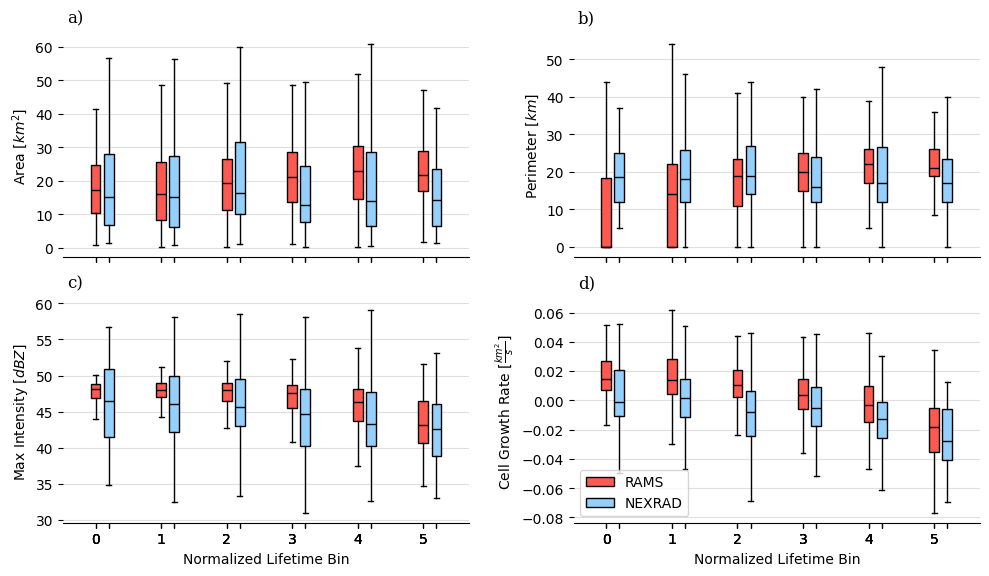

In [41]:
# viable variables: area, perimeter, speed, cell_growth
# var = "perimeter"
bins = 6
merged_cells = False # None - no preference on cells, False - only displays the unmerged cells, True - only displays the merged cells
lt40 = True # is the lifetime longer than 40 min

fig, axes = plt.subplots(2, 2, sharey=False, sharex=True, figsize=[10, 6])

for ind, var, let in zip(range(4), 
                            ["area", "perimeter", "max_intensity", "cell_growth"], 
                            ["a)", "b)", "c)", "d)"]
                        ):
    row = ind // 2
    col = ind - row * 2
    ax = axes[row, col]

    rams_boxplot_df = make_boxplot(RAMS_tracks_unfiltered, rams_analysis_data_unfiltered, var, bins=bins, model_name = "rams", longer_than_40_mins = lt40,
                                    merged_cells = merged_cells, mergers = rams_mergers)
    nexrad_boxplot_df = make_boxplot(NEXRAD_tracks_unfiltered, nexrad_analysis_data_unfiltered, var, bins=bins, model_name = "nexrad", longer_than_40_mins = lt40, 
                                    merged_cells = merged_cells, mergers = nexrad_mergers)
    rams_plot_groups = rams_boxplot_df.groupby("lifetime_bin")
    nexrad_plot_groups = nexrad_boxplot_df.groupby("lifetime_bin")

    # colors = ['red', 'blue', 'green']
    colors = ['xkcd:coral', 'xkcd:light blue']#, 'tomato']

    for bp_ind, rams_bp, nexrad_bp in zip(range(bins), rams_plot_groups, nexrad_plot_groups):
        if var == "cell_growth":
            rams_bp_plot = rams_bp[1]["max_var"].values / 5
        else:
            rams_bp_plot = rams_bp[1]["max_var"].values
        
        bplot = ax.boxplot([rams_bp_plot, nexrad_bp[1]["max_var"].values], 
                    positions= np.array([0.9, 1.1]) + 1 * rams_bp[0], 
                    showfliers = False, 
                    labels=[f"{rams_bp[0]}", ""],
                    patch_artist = True,)
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        for median in bplot['medians']:
            median.set_color('black')

    units_dict = {"area" : r" $[km^2]$", "perimeter" : r" $[km]$", "volume" : r" $[km^3]$", 
                    "max_intensity" : r" $[dBZ]$", "var_max_height" : r" $[km]$", "velocity" : r" $[m / s]$", 
                    "speed" : r" $[m / s]$", "cell_growth" : r" $[\frac{km^2}{s}]$", 
                    "sphericity" : r"", "convexity" : r""}
    title_dict = {"area" : "Area", "perimeter" : "Perimeter", "volume" : "Volume", 
                    "max_intensity" : "Max Intensity", "var_max_height" : "Max Height", "velocity" : "Velocity", 
                    "speed" : "Speed", "cell_growth" : "Cell Growth Rate", 
                    "sphericity" : "Sphericity", "convexity" : "Convexity"}

    if ind > 1:
        ax.set_xlabel("Normalized Lifetime Bin")
    else:
        ax.set_xlabel("")

    # plt.legend(["Standard Radar", "RAMS"])
    ax.set_ylabel(title_dict[var] + units_dict[var])
    # ax.grid(axis='y')
    ax.spines[['right', 'top', 'left']].set_visible(False)

    letter_xy = (-0.01, 1.15)

    ax.annotate(
        let,
        xy=letter_xy, xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize= 12, verticalalignment='top', fontfamily='serif',
        )
    
    ax.grid(axis='y', alpha=0.4)

if True:
    plt.suptitle("")

ax.legend([*bplot["boxes"]], ["RAMS", "NEXRAD"])
plt.tight_layout()
# fig.subplots_adjust(hspace=0.3)

plt.savefig("/D3/data/hweiner/model_obs_boxplots.png", dpi=600)
plt.show()